In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tf
import torchvision.datasets as tfds
import torchvision
from torchvision.transforms import ToPILImage

In [28]:
imgfolder = ImageFolder('./COVID-19_Radiography_Database/images/',
                       transform=tf.Compose([tf.Resize((1024,1024)),tf.ToTensor(),
                                            ]))

In [29]:
imgfolder

Dataset ImageFolder
    Number of datapoints: 2905
    Root location: ./COVID-19_Radiography_Database/images/
    StandardTransform
Transform: Compose(
               Resize(size=(1024, 1024), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [30]:
x = imgfolder.targets

In [31]:
d = {}
for i in x:
    if i in d.keys():
        d[i] += 1
    else:
        d[i] = 1

In [32]:
d

{0: 219, 1: 1341, 2: 1345}

In [8]:
x = list(imgfolder.class_to_idx.keys())

In [11]:
x

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [33]:
{i:j for i,j in zip(x, d.values())}

{0: 1345}

In [46]:
a = torch.utils.data.sampler.RandomSampler(imgfolder)

In [47]:
dataset_loader = torch.utils.data.DataLoader(imgfolder,
                                             batch_size=8, shuffle=True)

In [48]:
inpt, label  = next(iter(dataset_loader))

In [49]:
label

tensor([1, 1, 1, 2, 1, 2, 1, 2])

In [52]:
inpt.shape

torch.Size([8, 3, 1024, 1024])

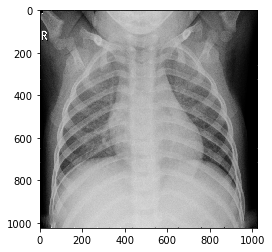

In [64]:
plt.imshow(inpt[4].permute(1,2,0))

In [69]:
def show(img):
    plt.imshow(img.permute(1,2,0))

In [71]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [75]:
label

tensor([1, 1, 1, 2, 1, 2, 1, 2])

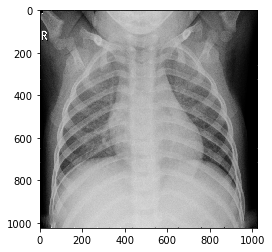

In [72]:
show(inpt[4])

In [121]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, stride=2, padding=3,) #512
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) #256
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) #128
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) #64
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.flatten = nn.Flatten()

        
        self.fc1 = nn.Linear(64*64*128, 120)  # 6*6 from image dimension
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(10,3)
        torch.nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)),3,1,1)
        x = F.avg_pool2d(F.relu(self.conv2(x)),3,1,1)
        x = F.avg_pool2d(F.relu(self.conv3(x)),3,1,1)
        x = F.avg_pool2d(F.relu(self.conv4(x)),3,1,1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x)
        return x



net = Net()

In [122]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, )

In [123]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [205]:
output = net(inpt)

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [202]:
for i in output:
    print(list(i).index(max(i)))
for i in label:
    print(i)

2
2
2
1
1
1
1
1
2
2
tensor(2)
tensor(2)
tensor(0)
tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(2)


In [206]:
loss = criterion(output, label)

In [207]:
loss

tensor(0.7149, grad_fn=<NllLossBackward>)